In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

## 0. Import module

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from PIL import Image

import sys
sys.path.append("../../src/")
sys.path.append("../")
import model
import dataset
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map

## Hyperparameter

In [7]:
resume = "081000-1"
num_class = 1
class_index = 0

## Load modal from dict

In [10]:
backbone = "vgg16"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
net = model.Network(backbone=backbone, num_classes=10, input_channel=1)
net.to(device)

# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt) 

Entire model.
Replace input channel with 1.
Resume from model from exp: 081000 at epoch 1


<All keys matched successfully>

In [11]:
summary(net, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 3.1 Load Original Data 

In [12]:
# Load data
mean, std = (0.1307,), (0.3081,)
reverse_mean = (-0.1307,)
reverse_std = (1/0.3081,)
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = dataset.MNIST(root="/media/lincolnzjx/HardDisk/Datasets/", 
                          is_train=True, transform=train_transform)

trainset.set_data([class_index], num_class)
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :1


In [13]:
# Move to device
original_image = torch.cat(images, dim=0).to(device)

In [14]:
color_map = "jet"

## Visualization Here.

In [15]:
layer_indexes = [2, 5, 8, 10, 13, 15, 18, 20]

---------------------------------------- 1 ----------------------------------------
=> Register fhook 1
Plot mode is => img_scale
Color map is => jet
Top-k => [6, 27, 13, 62, 38, 55, 20, 19, 14, 7]


<Figure size 432x288 with 0 Axes>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


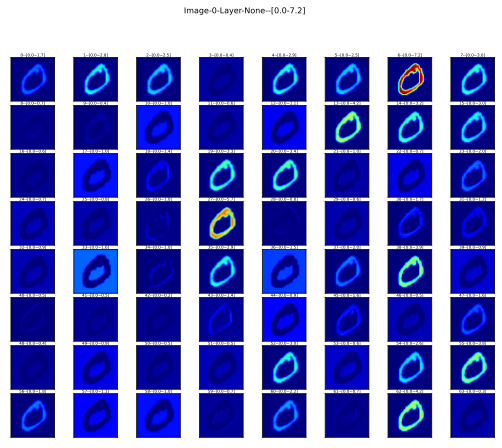

---------------------------------------- 4 ----------------------------------------
=> Register fhook 4
Plot mode is => img_scale
Color map is => jet
Top-k => [38, 31, 21, 35, 5, 27, 58, 62, 54, 23]


<Figure size 432x288 with 0 Axes>

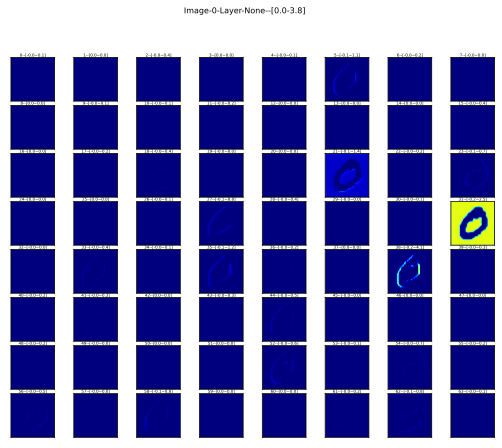

---------------------------------------- 7 ----------------------------------------
=> Register fhook 7
Plot mode is => img_scale
Color map is => jet
Top-k => [90, 56, 105, 30, 69, 40, 55, 111, 61, 18]


<Figure size 432x288 with 0 Axes>

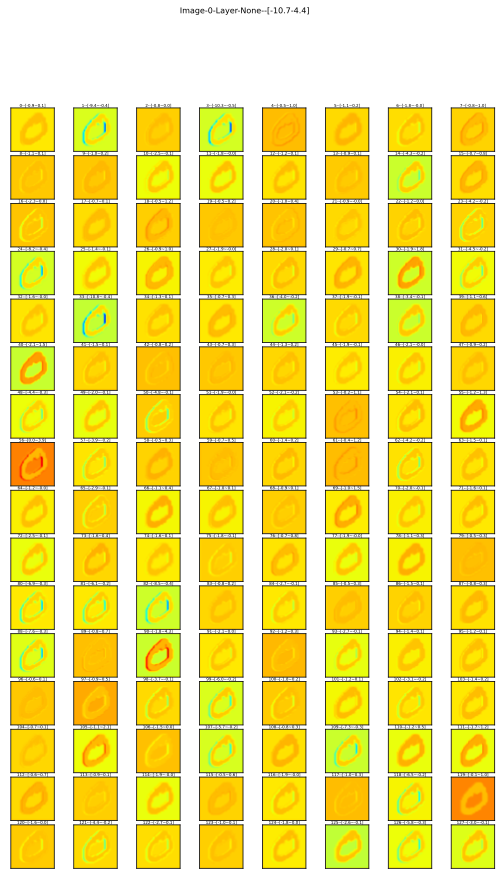

---------------------------------------- 9 ----------------------------------------
=> Register fhook 9
Plot mode is => img_scale
Color map is => jet
Top-k => [90, 56, 105, 30, 40, 69, 55, 18, 61, 111]


<Figure size 432x288 with 0 Axes>

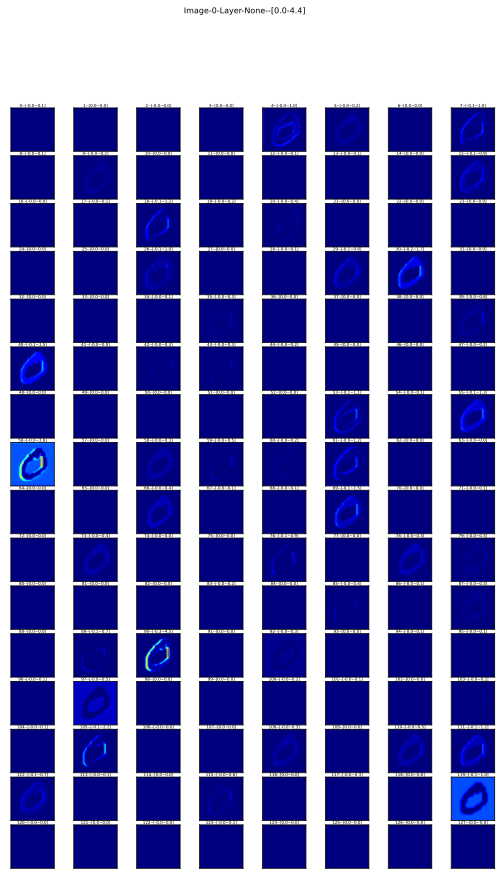

---------------------------------------- 12 ----------------------------------------
=> Register fhook 12
Plot mode is => img_scale
Color map is => jet
Top-k => [224, 36, 73, 217, 13, 148, 167, 109, 253, 25]


<Figure size 432x288 with 0 Axes>

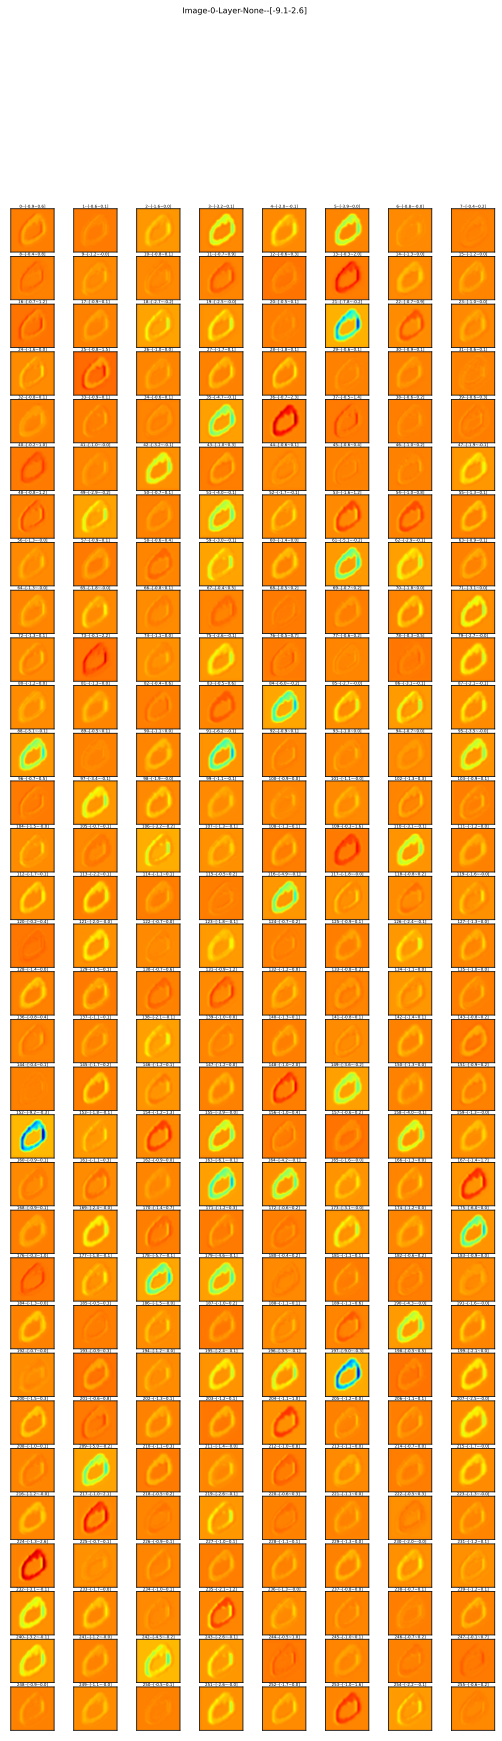

---------------------------------------- 14 ----------------------------------------
=> Register fhook 14
Plot mode is => img_scale
Color map is => jet
Top-k => [5, 222, 119, 18, 225, 150, 158, 133, 100, 68]


<Figure size 432x288 with 0 Axes>

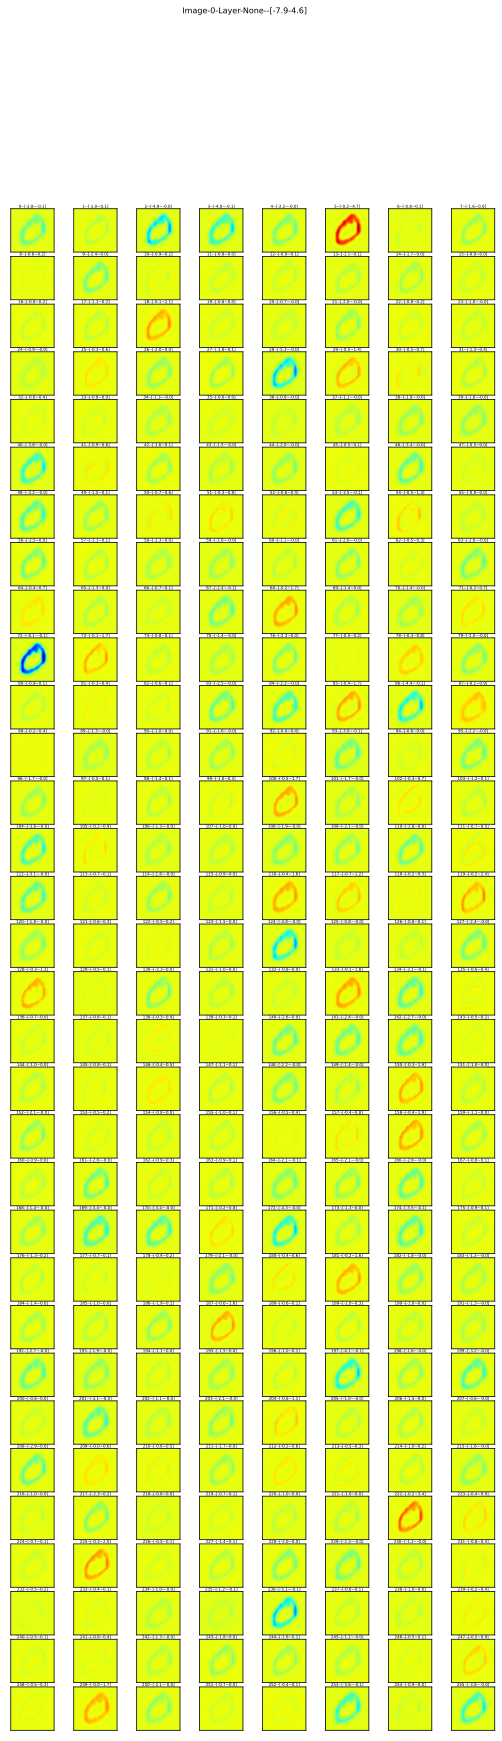

---------------------------------------- 17 ----------------------------------------
=> Register fhook 17
Plot mode is => img_scale
Color map is => jet
Top-k => [431, 101, 42, 172, 88, 332, 132, 410, 153, 247]


<Figure size 432x288 with 0 Axes>

---------------------------------------- 19 ----------------------------------------
=> Register fhook 19
Plot mode is => img_scale
Color map is => jet
Top-k => [75, 89, 459, 121, 349, 86, 101, 306, 382, 161]


<Figure size 432x288 with 0 Axes>

In [ ]:
for layer_index in layer_indexes:
    selected_layer = layer_index-1
    print("-"*40, selected_layer, "-"*40)
    layer_output = net.get_activation_maps(original_image, selected_layer)
    for img_index in range(num_class):
        visualize_features_map(img_index=img_index, 
                               features_map=layer_output, 
                               cols=8, 
                               #layer_index=0, 
                               #conv_output_index_dict=conv_output_indexes_dict, 
                               #save_dict=None, is_save=False,
                               plt_mode="img_scale", color_map=color_map) 